In [1]:
%load_ext autoreload
%autoreload 2

In [47]:
import yaml
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import pickle
from seaborn import histplot

In [21]:
os.chdir('/data/rsg/nlp/sdobers/amine/diffdock-protein/src')

from args import parse_args
from data import load_data, get_data
from data.data import BindingDataset
from model import load_model, to_cuda
from utils import printt, print_res, log, get_unixtime, compute_rmsd
from train import train, evaluate, evaluate_pose
from helpers import WandbLogger, TensorboardLogger
from sample import sample
from evaluation.compute_rmsd import evaluate_all_rmsds

In [4]:
from notebooks.utils_notebooks import Dict2Class

In [5]:
CUDA_VISIBLE_DEVICE = 0
torch.cuda.set_device(CUDA_VISIBLE_DEVICE)
print(torch.cuda.is_available())

True


In [6]:
#PATH = '/data/rsg/nlp/sdobers/amine/diffdock-protein/ckpts/dips_medium_model/'
#PATH = '/data/rsg/nlp/sdobers/amine/diffdock-protein/ckpts/dips_large_model/'
#PATH = '/data/rsg/nlp/sdobers/amine/diffdock-protein/ckpts/dips_medium_model_whole_data/'
#PATH = '/data/rsg/nlp/sdobers/amine/diffdock-protein/ckpts/dips_medium_model_faster' # medium model
PATH = '/data/rsg/nlp/sdobers/amine/diffdock-protein/ckpts/dips_largest_model' # largest model

In [7]:
# load args
with open(os.path.join(PATH, 'args.yaml')) as f:
    args = yaml.safe_load(f)
args = Dict2Class(args)

args.num_gpu = 1
args.gpu = CUDA_VISIBLE_DEVICE
args.data_file = args.data_file.replace('data_file', 'data_file_100_test')
args.checkpoint_path = PATH
#args.use_orientation_features = False
#args.recache = False
args.batch_size = 32
if 'large' in PATH:
    args.batch_size = 4
#args.cross_cutoff_weight = 3
#args.cross_cutoff_bias = 40

In [8]:
# load raw data
data = load_data(args)
data_params = data.data_params

data loading: 100%|█| 100/100 [00:00<00:00, 530924


05:53:00 Loaded cached ESM embeddings
05:53:00 finished tokenizing residues with ESM
05:53:00 finished tokenizing all inputs
05:53:00 100 entries loaded


In [9]:
# only val data
val_dataset = BindingDataset(args, data.data, apply_transform=False)

# all data
#loaders_for_reverse_diffusion = get_data(data, 0, args, for_reverse_diffusion=True)

In [10]:
len(val_dataset)

100

In [ ]:
for protein_complex in val_dataset:
    print(protein_complex.name)

In [12]:
# get model and load checkpoint, if relevant
model = load_model(args, data_params, 0, load_best=True)
model = to_cuda(model, args)

numel = sum([p.numel() for p in model.parameters()])
printt('Model with', numel, 'parameters')

/data/rsg/nlp/sdobers/miniconda3/envs/diffdock_protein/lib/python3.10/site-packages/torch/jit/_check.py:181: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


05:54:02 loaded model with kwargs: 
05:54:02 loaded checkpoint from /data/rsg/nlp/sdobers/amine/diffdock-protein/ckpts/dips_largest_model/fold_0/model_best_265818_110_33.815_33.219.pth
05:54:16 Model with 1617666 parameters


In [68]:
#random_indices = np.random.choice(len(loaders_for_reverse_diffusion["train"]), size=240, replace=False)
#data_list = loaders_for_reverse_diffusion["train"][random_indices]

#data_list = BindingDataset(args, {}, apply_transform=False)
#data_list.data = [loaders_for_reverse_diffusion["train"].data[i] for i in random_indices]
#data_list.length = len(data_list.data)


## TOP1

In [16]:
# run reverse diffusion process
samples_val = sample(val_dataset, model, args)
# samples_val now contains all the graphs, with graph["ligand"] contains the positions predicted by the model

06:09:13 Completed 0 out of 40 steps
06:09:33 Completed 1 out of 40 steps
06:09:52 Completed 2 out of 40 steps
06:10:11 Completed 3 out of 40 steps
06:10:28 Completed 4 out of 40 steps
06:10:45 Completed 5 out of 40 steps
06:11:00 Completed 6 out of 40 steps
06:11:14 Completed 7 out of 40 steps
06:11:27 Completed 8 out of 40 steps
06:11:39 Completed 9 out of 40 steps
06:11:51 Completed 10 out of 40 steps
06:12:01 Completed 11 out of 40 steps
06:12:11 Completed 12 out of 40 steps
06:12:21 Completed 13 out of 40 steps
06:12:30 Completed 14 out of 40 steps
06:12:39 Completed 15 out of 40 steps
06:12:47 Completed 16 out of 40 steps
06:12:55 Completed 17 out of 40 steps
06:13:02 Completed 18 out of 40 steps
06:13:09 Completed 19 out of 40 steps
06:13:17 Completed 20 out of 40 steps
06:13:24 Completed 21 out of 40 steps
06:13:31 Completed 22 out of 40 steps
06:13:39 Completed 23 out of 40 steps
06:13:46 Completed 24 out of 40 steps
06:13:52 Completed 25 out of 40 steps
06:13:59 Completed 26 

In [17]:
val_score = evaluate_pose(val_dataset, samples_val)

In [20]:
rmsds = np.array(val_score["rmsd"])
reverse_diffusion_metrics = {'rmsds_lt2': (100 * (rmsds < 2).sum() / len(rmsds)),
                             'rmsds_lt5': (100 * (rmsds < 5).sum() / len(rmsds)),
                             'rmsds_lt10': (100 * (rmsds < 10).sum() / len(rmsds)),
                             'rmsds_mean': rmsds.mean(),
                             'rmsds_median': np.median(rmsds)}
print(reverse_diffusion_metrics)

{'rmsds_lt2': 12.0, 'rmsds_lt5': 18.0, 'rmsds_lt10': 25.0, 'rmsds_mean': 35.932213, 'rmsds_median': 37.739902}


In [25]:
ligand_rmsd_summarized, complex_rmsd_summarized, interface_rmsd_summarized = evaluate_all_rmsds(val_dataset, samples_val)




In [26]:
ligand_rmsd_summarized

{'mean': 35.932213,
 'median': 37.739906,
 'std': 25.059593,
 'lt1': 4.0,
 'lt2': 12.0,
 'lt5': 18.0,
 'lt10': 25.0}

In [27]:
complex_rmsd_summarized

{'mean': 14.54395289705735,
 'median': 16.145159846859734,
 'std': 9.759590879415219,
 'lt1': 14.0,
 'lt2': 19.0,
 'lt5': 25.0,
 'lt10': 34.0}

In [28]:
interface_rmsd_summarized

{'mean': 13.469448702427941,
 'median': 13.020660483970541,
 'std': 10.380044156029424,
 'lt1': 16.0,
 'lt2': 21.0,
 'lt5': 28.0,
 'lt10': 36.0}

In [31]:
with open('/data/rsg/nlp/sdobers/cedrik/diffdock-protein/storage/dips_esm_inference_10samples_large.pkl', "rb") as f:
    results = pickle.load(f)

In [33]:
len(results)

100

In [34]:
gt = [res[0][0] for res in results]
best_pred = [res[1][0] for res in results]

In [40]:
meter, ligand_rmsd_10s, complex_rmsd_10s, interface_rmsd_10s = evaluate_all_rmsds(gt, best_pred)


In [41]:
ligand_rmsd_10s

{'mean': 32.97904,
 'median': 33.13714,
 'std': 29.957193,
 'lt1': 7.0,
 'lt2': 17.0,
 'lt5': 31.0,
 'lt10': 38.0}

In [42]:
complex_rmsd_10s

{'mean': 12.876473048634935,
 'median': 12.593231201171875,
 'std': 11.481786117629763,
 'lt1': 23.0,
 'lt2': 31.0,
 'lt5': 40.0,
 'lt10': 46.0}

In [43]:
interface_rmsd_10s

{'mean': 11.047447171517533,
 'median': 10.044833183288574,
 'std': 11.139125768275223,
 'lt1': 23.0,
 'lt2': 35.0,
 'lt5': 42.0,
 'lt10': 50.0}

[Text(0.5, 1.0, 'TOP 1'), Text(0.5, 0, 'Ligand RMSD')]

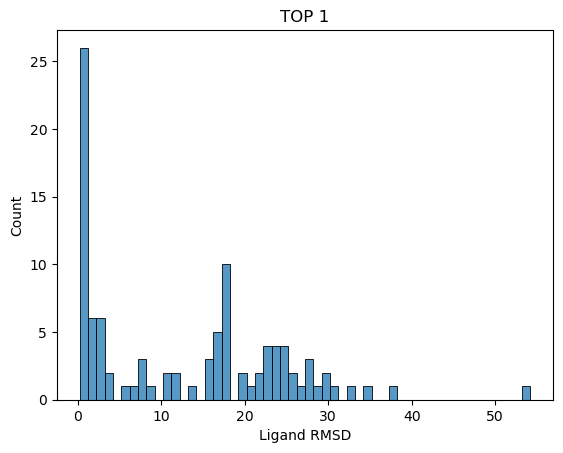

In [48]:
histplot(data=meter.complex_rmsd_list, binwidth=1).set(title='TOP 1', xlabel='Ligand RMSD')


In [59]:
with open('/data/rsg/nlp/sdobers/cedrik/diffdock-protein/storage/db5_bound_esm_inference_10samples_large.pkl', "rb") as f:
    results_db5 = pickle.load(f)
    

In [60]:
gt_db5 = [res[0][0] for res in results_db5]
best_pred_db5 = [res[1][0] for res in results_db5]

In [61]:
meter, ligand_rmsd_10s, complex_rmsd_10s, interface_rmsd_10s = evaluate_all_rmsds(gt_db5, best_pred_dbr)


In [62]:
ligand_rmsd_10s

{'mean': 43.380062,
 'median': 40.79326,
 'std': 17.794231,
 'lt1': 0.0,
 'lt2': 0.0,
 'lt5': 0.0,
 'lt10': 0.0}

In [63]:
complex_rmsd_10s

{'mean': 15.782947379929078,
 'median': 15.296611785888672,
 'std': 5.529170687474491,
 'lt1': 0.0,
 'lt2': 0.0,
 'lt5': 0.0,
 'lt10': 16.0}

[Text(0.5, 1.0, '10 samples + confidence_model'), Text(0.5, 0, 'Complex RMSD')]

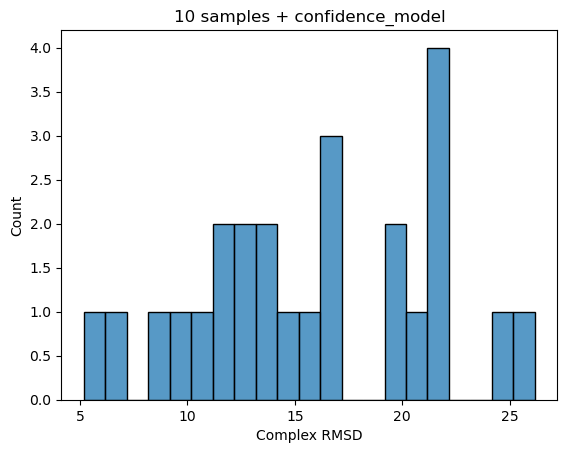

In [64]:
histplot(data=meter.complex_rmsd_list, binwidth=1).set(title='10 samples + confidence_model', xlabel='Complex RMSD')


In [36]:
rmsds = np.array(val_score["rmsd"])
reverse_diffusion_metrics = {'rmsds_lt2': (100 * (rmsds < 2).sum() / len(rmsds)),
                             'rmsds_lt5': (100 * (rmsds < 5).sum() / len(rmsds)),
                             'rmsds_lt10': (100 * (rmsds < 10).sum() / len(rmsds)),
                             'rmsds_mean': rmsds.mean(),
                             'rmsds_median': np.median(rmsds)}
print(reverse_diffusion_metrics)

{'rmsds_lt2': 11.0, 'rmsds_lt5': 18.0, 'rmsds_lt10': 21.0, 'rmsds_mean': 38.2204, 'rmsds_median': 39.766003}


In [34]:
rmsds

array([ 63.310364  ,  79.72629   ,  35.34724   ,  52.167233  ,
        36.00924   ,  29.859137  ,   0.84258753,  75.09546   ,
        72.506165  ,   1.0409733 ,  66.89711   ,   1.8664917 ,
         2.7314756 ,  49.308174  ,  11.20348   ,   3.539894  ,
        30.613865  ,  42.536293  ,   2.4689188 ,   8.948506  ,
         5.3857756 ,  64.42251   ,  63.34643   ,  64.62098   ,
        67.06998   ,   5.9819074 ,  28.0428    ,   6.728376  ,
        69.97631   ,  64.42916   ,   5.0846624 ,  76.03727   ,
        30.298376  ,   5.2708836 ,  33.296852  ,  74.989845  ,
        72.33864   ,   1.161579  ,  35.76681   ,  49.870506  ,
        49.12135   ,  43.238533  ,  48.398174  ,  54.79541   ,
        31.303381  ,  36.042377  ,  47.700184  ,  43.528893  ,
        44.6185    ,   0.8267346 ,  56.972694  ,  50.800564  ,
        49.456905  ,  46.044483  ,   4.466696  ,  23.387299  ,
        43.930008  ,  47.754055  ,   8.26316   ,  37.328392  ,
        49.175694  ,  51.337128  ,   1.631422  ,   2.24

In [46]:
from seaborn import histplot

In [16]:
rmsds_copy = copy.deepcopy(rmsds)

In [25]:
#rmsds_copy[rmsds_copy==rmsds_copy.max()] = 100

In [26]:
#rmsds_copy.max()

100.0

[Text(0.5, 1.0, 'TOP 1'), Text(0.5, 0, 'Ligand RMSD')]

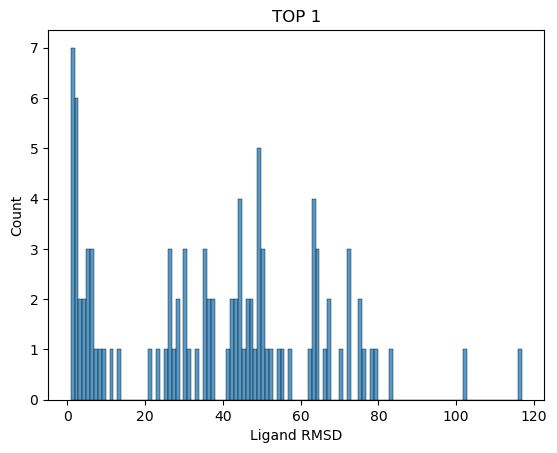

In [30]:
histplot(data=rmsds_copy, binwidth=1).set(title='TOP 1', xlabel='Ligand RMSD')

## tr_s_max=20

In [40]:
args.tr_s_max = 20.0
args.tr_s_max

20.0

In [41]:
# run reverse diffusion process
samples_val = sample(val_dataset, model, args)
# samples_val now contains all the graphs, with graph["ligand"] contains the positions predicted by the model

05:13:59 Completed 0 out of 40 steps
05:14:17 Completed 1 out of 40 steps
05:14:34 Completed 2 out of 40 steps
05:14:51 Completed 3 out of 40 steps
05:15:07 Completed 4 out of 40 steps
05:15:22 Completed 5 out of 40 steps
05:15:36 Completed 6 out of 40 steps
05:15:49 Completed 7 out of 40 steps
05:16:01 Completed 8 out of 40 steps
05:16:13 Completed 9 out of 40 steps
05:16:24 Completed 10 out of 40 steps
05:16:34 Completed 11 out of 40 steps
05:16:44 Completed 12 out of 40 steps
05:16:53 Completed 13 out of 40 steps
05:17:02 Completed 14 out of 40 steps
05:17:11 Completed 15 out of 40 steps
05:17:19 Completed 16 out of 40 steps
05:17:27 Completed 17 out of 40 steps
05:17:35 Completed 18 out of 40 steps
05:17:43 Completed 19 out of 40 steps
05:17:50 Completed 20 out of 40 steps
05:17:57 Completed 21 out of 40 steps
05:18:04 Completed 22 out of 40 steps
05:18:12 Completed 23 out of 40 steps
05:18:19 Completed 24 out of 40 steps
05:18:26 Completed 25 out of 40 steps
05:18:33 Completed 26 

In [42]:
val_score = evaluate_pose(val_dataset, samples_val)

In [43]:
rmsds = np.array(val_score["rmsd"])
reverse_diffusion_metrics = {'rmsds_lt2': (100 * (rmsds < 2).sum() / len(rmsds)),
                             'rmsds_lt5': (100 * (rmsds < 5).sum() / len(rmsds)),
                             'rmsds_lt10': (100 * (rmsds < 10).sum() / len(rmsds)),
                             'rmsds_mean': rmsds.mean(),
                             'rmsds_median': np.median(rmsds)}
print(reverse_diffusion_metrics)

{'rmsds_lt2': 8.0, 'rmsds_lt5': 14.0, 'rmsds_lt10': 18.0, 'rmsds_mean': 39.8523, 'rmsds_median': 41.25315}


## TOP5

In [19]:
n_runs = 5
rmsds_top5 = np.full(len(val_dataset), np.inf)
for i in tqdm(range(n_runs)):
    print(f'----------------- in iteration {i} -----------------')
    # run reverse diffusion process
    samples_val = sample(val_dataset, model, args)
    # samples_val now contains all the graphs, with graph["ligand"] contains the positions predicted by the model
    val_score = evaluate_pose(val_dataset, samples_val)
    rmsds_i = np.array(val_score["rmsd"])
    print(f'in iteration {i}: mean is {rmsds_i.mean()}')
    rmsds_top5 = np.minimum(rmsds_top5, rmsds_i)
    print(f'in iteration {i}: mean with confidence model is {rmsds_top5.mean()}')
print(f'Final result: {rmsds_top5.mean()}')

  0%|          | 0/5 [00:00<?, ?it/s]

----------------- in iteration 0 -----------------
04:14:37 Completed 0 out of 40 steps
04:14:53 Completed 1 out of 40 steps
04:15:09 Completed 2 out of 40 steps
04:15:25 Completed 3 out of 40 steps
04:15:40 Completed 4 out of 40 steps
04:15:54 Completed 5 out of 40 steps
04:16:08 Completed 6 out of 40 steps
04:16:20 Completed 7 out of 40 steps
04:16:32 Completed 8 out of 40 steps
04:16:43 Completed 9 out of 40 steps
04:16:52 Completed 10 out of 40 steps
04:17:02 Completed 11 out of 40 steps
04:17:10 Completed 12 out of 40 steps
04:17:19 Completed 13 out of 40 steps
04:17:27 Completed 14 out of 40 steps
04:17:35 Completed 15 out of 40 steps
04:17:42 Completed 16 out of 40 steps
04:17:49 Completed 17 out of 40 steps
04:17:56 Completed 18 out of 40 steps
04:18:03 Completed 19 out of 40 steps
04:18:10 Completed 20 out of 40 steps
04:18:17 Completed 21 out of 40 steps
04:18:23 Completed 22 out of 40 steps
04:18:30 Completed 23 out of 40 steps
04:18:36 Completed 24 out of 40 steps
04:18:42 

 20%|██        | 1/5 [05:50<23:20, 350.10s/it]

04:20:09 Completed 39 out of 40 steps
in iteration 0: mean is 37.2067756652832
in iteration 0: mean with confidence model is 37.20677823066711
----------------- in iteration 1 -----------------
04:20:27 Completed 0 out of 40 steps
04:20:44 Completed 1 out of 40 steps
04:21:01 Completed 2 out of 40 steps
04:21:17 Completed 3 out of 40 steps
04:21:32 Completed 4 out of 40 steps
04:21:47 Completed 5 out of 40 steps
04:22:01 Completed 6 out of 40 steps
04:22:14 Completed 7 out of 40 steps
04:22:27 Completed 8 out of 40 steps
04:22:38 Completed 9 out of 40 steps
04:22:49 Completed 10 out of 40 steps
04:22:59 Completed 11 out of 40 steps
04:23:09 Completed 12 out of 40 steps
04:23:18 Completed 13 out of 40 steps
04:23:26 Completed 14 out of 40 steps
04:23:34 Completed 15 out of 40 steps
04:23:42 Completed 16 out of 40 steps
04:23:49 Completed 17 out of 40 steps
04:23:57 Completed 18 out of 40 steps
04:24:04 Completed 19 out of 40 steps
04:24:11 Completed 20 out of 40 steps
04:24:18 Completed

 40%|████      | 2/5 [11:55<17:57, 359.21s/it]

04:26:14 Completed 39 out of 40 steps
in iteration 1: mean is 36.8116569519043
in iteration 1: mean with confidence model is 28.087495579123498
----------------- in iteration 2 -----------------
04:26:33 Completed 0 out of 40 steps
04:26:49 Completed 1 out of 40 steps
04:27:05 Completed 2 out of 40 steps
04:27:21 Completed 3 out of 40 steps
04:27:36 Completed 4 out of 40 steps
04:27:51 Completed 5 out of 40 steps
04:28:04 Completed 6 out of 40 steps
04:28:17 Completed 7 out of 40 steps
04:28:28 Completed 8 out of 40 steps
04:28:39 Completed 9 out of 40 steps
04:28:49 Completed 10 out of 40 steps
04:28:58 Completed 11 out of 40 steps
04:29:07 Completed 12 out of 40 steps
04:29:15 Completed 13 out of 40 steps
04:29:23 Completed 14 out of 40 steps
04:29:31 Completed 15 out of 40 steps
04:29:38 Completed 16 out of 40 steps
04:29:45 Completed 17 out of 40 steps
04:29:52 Completed 18 out of 40 steps
04:29:59 Completed 19 out of 40 steps
04:30:06 Completed 20 out of 40 steps
04:30:13 Complete

 60%|██████    | 3/5 [17:48<11:52, 356.15s/it]

04:32:07 Completed 39 out of 40 steps
in iteration 2: mean is 39.16838073730469
in iteration 2: mean with confidence model is 22.48971390247345
----------------- in iteration 3 -----------------
04:32:26 Completed 0 out of 40 steps
04:32:42 Completed 1 out of 40 steps
04:32:58 Completed 2 out of 40 steps
04:33:14 Completed 3 out of 40 steps
04:33:29 Completed 4 out of 40 steps
04:33:42 Completed 5 out of 40 steps
04:33:55 Completed 6 out of 40 steps
04:34:07 Completed 7 out of 40 steps
04:34:18 Completed 8 out of 40 steps
04:34:29 Completed 9 out of 40 steps
04:34:39 Completed 10 out of 40 steps
04:34:47 Completed 11 out of 40 steps
04:34:56 Completed 12 out of 40 steps
04:35:04 Completed 13 out of 40 steps
04:35:11 Completed 14 out of 40 steps
04:35:18 Completed 15 out of 40 steps
04:35:25 Completed 16 out of 40 steps
04:35:32 Completed 17 out of 40 steps
04:35:38 Completed 18 out of 40 steps
04:35:44 Completed 19 out of 40 steps
04:35:51 Completed 20 out of 40 steps
04:35:57 Complete

 80%|████████  | 4/5 [23:24<05:48, 348.19s/it]

04:37:43 Completed 39 out of 40 steps
in iteration 3: mean is 36.95976257324219
in iteration 3: mean with confidence model is 20.181509137153625
----------------- in iteration 4 -----------------
04:38:01 Completed 0 out of 40 steps
04:38:18 Completed 1 out of 40 steps
04:38:34 Completed 2 out of 40 steps
04:38:50 Completed 3 out of 40 steps
04:39:05 Completed 4 out of 40 steps
04:39:19 Completed 5 out of 40 steps
04:39:32 Completed 6 out of 40 steps
04:39:45 Completed 7 out of 40 steps
04:39:57 Completed 8 out of 40 steps
04:40:08 Completed 9 out of 40 steps
04:40:18 Completed 10 out of 40 steps
04:40:28 Completed 11 out of 40 steps
04:40:38 Completed 12 out of 40 steps
04:40:47 Completed 13 out of 40 steps
04:40:55 Completed 14 out of 40 steps
04:41:03 Completed 15 out of 40 steps
04:41:11 Completed 16 out of 40 steps
04:41:19 Completed 17 out of 40 steps
04:41:26 Completed 18 out of 40 steps
04:41:33 Completed 19 out of 40 steps
04:41:40 Completed 20 out of 40 steps
04:41:48 Complet

100%|██████████| 5/5 [29:25<00:00, 353.18s/it]

04:43:45 Completed 39 out of 40 steps
in iteration 4: mean is 36.70817565917969
in iteration 4: mean with confidence model is 18.381002537608147
Final result: 18.381002537608147


In [35]:
rmsds_top5

array([53.46282959, 53.19362259,  0.6379019 ,  2.92285776, 21.42480087,
       10.45095444,  0.6221807 ,  4.80261898,  4.14194965,  0.98054582,
        2.88560534,  2.24601984,  2.1364162 , 43.16273117, 28.72454453,
        0.78918064,  3.73767829,  6.21679449, 44.56354141, 13.36374569,
        9.75408649, 22.08468628, 24.14403343, 58.44140244, 48.95568466,
       25.48816299, 59.46939468,  3.22588587, 35.95549011, 23.48176003,
        4.95803261, 20.43234062,  1.60881162,  1.65167415,  6.16278648,
       46.36700058, 39.18304443,  0.59602511,  3.00870228, 16.03627586,
       30.67551422,  2.38860583, 19.18674278, 14.27074623, 16.58966446,
        7.08420849,  1.49936676,  6.4408412 ,  1.4611975 ,  0.90240657,
        5.52811766,  1.56534076, 28.91121292,  3.17402792,  3.72631931,
       22.47725105,  1.68672764, 51.10634232,  2.8482523 , 10.1975317 ,
       22.46019554, 11.90663433,  0.72928089,  1.31657338, 21.9049015 ,
       40.58083344, 29.26492882, 46.34368134,  2.63078189, 19.35

In [21]:
reverse_diffusion_metrics_top5 = {'rmsds_top5_lt2': (100 * (rmsds_top5 < 2).sum() / len(rmsds_top5)),
                             'rmsds_top5_lt5': (100 * (rmsds_top5 < 5).sum() / len(rmsds_top5)),
                             'rmsds_top5_lt10': (100 * (rmsds_top5 < 10).sum() / len(rmsds_top5)),
                             'rmsds_top5_mean': rmsds_top5.mean(),
                             'rmsds_top5_median': np.median(rmsds_top5)}
print(reverse_diffusion_metrics_top5)

{'rmsds_top5_lt2': 19.0, 'rmsds_top5_lt5': 38.0, 'rmsds_top5_lt10': 48.0, 'rmsds_top5_mean': 18.381002537608147, 'rmsds_top5_median': 11.178794384002686}


[Text(0.5, 1.0, 'TOP 5'), Text(0.5, 0, 'Ligand RMSD')]

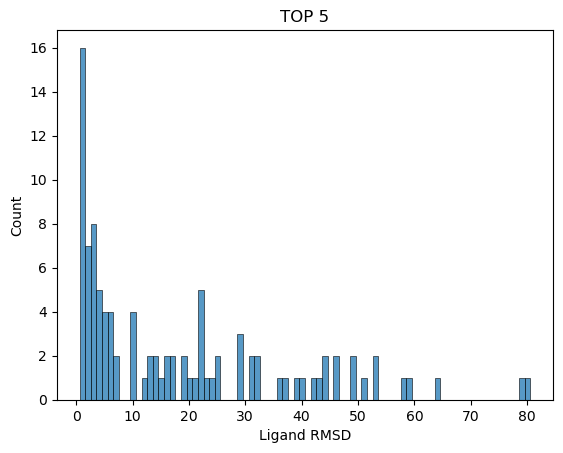

In [26]:
rmsds_top5_copy = copy.deepcopy(rmsds_top5)
histplot(data=rmsds_top5_copy, binwidth=1).set(title='TOP 5', xlabel='Ligand RMSD')

## TOP 10

In [27]:
n_runs = 10
rmsds_top10 = np.full(len(val_dataset), np.inf)
for i in tqdm(range(n_runs)):
    print(f'----------------- in iteration {i} -----------------')
    # run reverse diffusion process
    samples_val = sample(val_dataset, model, args)
    # samples_val now contains all the graphs, with graph["ligand"] contains the positions predicted by the model
    val_score = evaluate_pose(val_dataset, samples_val)
    rmsds_i = np.array(val_score["rmsd"])
    print(f'in iteration {i}: mean is {rmsds_i.mean()}')
    rmsds_top10 = np.minimum(rmsds_top10, rmsds_i)
    print(f'in iteration {i}: mean with confidence model is {rmsds_top10.mean()}')
print(f'Final result: {rmsds_top10.mean()}')

  0%|          | 0/10 [00:00<?, ?it/s]

----------------- in iteration 0 -----------------
04:58:26 Completed 0 out of 40 steps
04:58:42 Completed 1 out of 40 steps
04:58:58 Completed 2 out of 40 steps
04:59:13 Completed 3 out of 40 steps
04:59:28 Completed 4 out of 40 steps
04:59:41 Completed 5 out of 40 steps
04:59:54 Completed 6 out of 40 steps
05:00:06 Completed 7 out of 40 steps
05:00:17 Completed 8 out of 40 steps
05:00:27 Completed 9 out of 40 steps
05:00:37 Completed 10 out of 40 steps
05:00:46 Completed 11 out of 40 steps
05:00:54 Completed 12 out of 40 steps
05:01:02 Completed 13 out of 40 steps
05:01:10 Completed 14 out of 40 steps
05:01:17 Completed 15 out of 40 steps
05:01:24 Completed 16 out of 40 steps
05:01:31 Completed 17 out of 40 steps
05:01:38 Completed 18 out of 40 steps
05:01:44 Completed 19 out of 40 steps
05:01:50 Completed 20 out of 40 steps
05:01:57 Completed 21 out of 40 steps
05:02:03 Completed 22 out of 40 steps
05:02:09 Completed 23 out of 40 steps
05:02:15 Completed 24 out of 40 steps
05:02:21 

 10%|█         | 1/10 [05:34<50:10, 334.53s/it]

in iteration 0: mean is 38.20854568481445
in iteration 0: mean with confidence model is 38.20854960203171
----------------- in iteration 1 -----------------
05:04:00 Completed 0 out of 40 steps
05:04:16 Completed 1 out of 40 steps
05:04:33 Completed 2 out of 40 steps
05:04:49 Completed 3 out of 40 steps
05:05:05 Completed 4 out of 40 steps
05:05:19 Completed 5 out of 40 steps
05:05:33 Completed 6 out of 40 steps
05:05:47 Completed 7 out of 40 steps
05:05:59 Completed 8 out of 40 steps
05:06:10 Completed 9 out of 40 steps
05:06:20 Completed 10 out of 40 steps
05:06:30 Completed 11 out of 40 steps
05:06:39 Completed 12 out of 40 steps
05:06:47 Completed 13 out of 40 steps
05:06:55 Completed 14 out of 40 steps
05:07:03 Completed 15 out of 40 steps
05:07:10 Completed 16 out of 40 steps
05:07:17 Completed 17 out of 40 steps
05:07:24 Completed 18 out of 40 steps
05:07:31 Completed 19 out of 40 steps
05:07:38 Completed 20 out of 40 steps
05:07:45 Completed 21 out of 40 steps
05:07:51 Complete

 20%|██        | 2/10 [11:30<46:16, 347.05s/it]

05:09:38 Completed 39 out of 40 steps
in iteration 1: mean is 35.59917068481445
in iteration 1: mean with confidence model is 27.56089868605137
----------------- in iteration 2 -----------------
05:09:57 Completed 0 out of 40 steps
05:10:14 Completed 1 out of 40 steps
05:10:30 Completed 2 out of 40 steps
05:10:46 Completed 3 out of 40 steps
05:11:00 Completed 4 out of 40 steps
05:11:14 Completed 5 out of 40 steps
05:11:28 Completed 6 out of 40 steps
05:11:41 Completed 7 out of 40 steps
05:11:53 Completed 8 out of 40 steps
05:12:04 Completed 9 out of 40 steps
05:12:14 Completed 10 out of 40 steps
05:12:24 Completed 11 out of 40 steps
05:12:33 Completed 12 out of 40 steps
05:12:42 Completed 13 out of 40 steps
05:12:50 Completed 14 out of 40 steps
05:12:58 Completed 15 out of 40 steps
05:13:05 Completed 16 out of 40 steps
05:13:12 Completed 17 out of 40 steps
05:13:19 Completed 18 out of 40 steps
05:13:26 Completed 19 out of 40 steps
05:13:33 Completed 20 out of 40 steps
05:13:40 Complete

 30%|███       | 3/10 [17:26<40:57, 351.02s/it]

in iteration 2: mean is 37.40066146850586
in iteration 2: mean with confidence model is 23.361004276871682
----------------- in iteration 3 -----------------
05:15:52 Completed 0 out of 40 steps
05:16:09 Completed 1 out of 40 steps
05:16:25 Completed 2 out of 40 steps
05:16:41 Completed 3 out of 40 steps
05:16:56 Completed 4 out of 40 steps
05:17:10 Completed 5 out of 40 steps
05:17:23 Completed 6 out of 40 steps
05:17:36 Completed 7 out of 40 steps
05:17:48 Completed 8 out of 40 steps
05:17:58 Completed 9 out of 40 steps
05:18:08 Completed 10 out of 40 steps
05:18:17 Completed 11 out of 40 steps
05:18:26 Completed 12 out of 40 steps
05:18:34 Completed 13 out of 40 steps
05:18:42 Completed 14 out of 40 steps
05:18:50 Completed 15 out of 40 steps
05:18:57 Completed 16 out of 40 steps
05:19:04 Completed 17 out of 40 steps
05:19:11 Completed 18 out of 40 steps
05:19:18 Completed 19 out of 40 steps
05:19:24 Completed 20 out of 40 steps
05:19:31 Completed 21 out of 40 steps
05:19:37 Complet

 40%|████      | 4/10 [23:12<34:55, 349.30s/it]

05:21:20 Completed 39 out of 40 steps
in iteration 3: mean is 38.00582504272461
in iteration 3: mean with confidence model is 21.212053907513617
----------------- in iteration 4 -----------------
05:21:39 Completed 0 out of 40 steps
05:21:55 Completed 1 out of 40 steps
05:22:12 Completed 2 out of 40 steps
05:22:28 Completed 3 out of 40 steps
05:22:44 Completed 4 out of 40 steps
05:22:59 Completed 5 out of 40 steps
05:23:13 Completed 6 out of 40 steps
05:23:27 Completed 7 out of 40 steps
05:23:39 Completed 8 out of 40 steps
05:23:51 Completed 9 out of 40 steps
05:24:01 Completed 10 out of 40 steps
05:24:11 Completed 11 out of 40 steps
05:24:21 Completed 12 out of 40 steps
05:24:30 Completed 13 out of 40 steps
05:24:38 Completed 14 out of 40 steps
05:24:47 Completed 15 out of 40 steps
05:24:54 Completed 16 out of 40 steps
05:25:02 Completed 17 out of 40 steps
05:25:10 Completed 18 out of 40 steps
05:25:17 Completed 19 out of 40 steps
05:25:24 Completed 20 out of 40 steps
05:25:31 Complet

 50%|█████     | 5/10 [29:22<29:43, 356.70s/it]

05:27:30 Completed 39 out of 40 steps
in iteration 4: mean is 35.54689025878906
in iteration 4: mean with confidence model is 18.289339078068732
----------------- in iteration 5 -----------------
05:27:49 Completed 0 out of 40 steps
05:28:06 Completed 1 out of 40 steps
05:28:22 Completed 2 out of 40 steps
05:28:39 Completed 3 out of 40 steps
05:28:55 Completed 4 out of 40 steps
05:29:10 Completed 5 out of 40 steps
05:29:25 Completed 6 out of 40 steps
05:29:38 Completed 7 out of 40 steps
05:29:50 Completed 8 out of 40 steps
05:30:02 Completed 9 out of 40 steps
05:30:13 Completed 10 out of 40 steps
05:30:23 Completed 11 out of 40 steps
05:30:32 Completed 12 out of 40 steps
05:30:41 Completed 13 out of 40 steps
05:30:50 Completed 14 out of 40 steps
05:30:58 Completed 15 out of 40 steps
05:31:06 Completed 16 out of 40 steps
05:31:13 Completed 17 out of 40 steps
05:31:20 Completed 18 out of 40 steps
05:31:27 Completed 19 out of 40 steps
05:31:34 Completed 20 out of 40 steps
05:31:41 Complet

 60%|██████    | 6/10 [35:27<23:57, 359.44s/it]

05:33:35 Completed 39 out of 40 steps
in iteration 5: mean is 37.982421875
in iteration 5: mean with confidence model is 17.537189728021623
----------------- in iteration 6 -----------------
05:33:53 Completed 0 out of 40 steps
05:34:10 Completed 1 out of 40 steps
05:34:26 Completed 2 out of 40 steps
05:34:43 Completed 3 out of 40 steps
05:34:58 Completed 4 out of 40 steps
05:35:12 Completed 5 out of 40 steps
05:35:26 Completed 6 out of 40 steps
05:35:38 Completed 7 out of 40 steps
05:35:50 Completed 8 out of 40 steps
05:36:01 Completed 9 out of 40 steps
05:36:10 Completed 10 out of 40 steps
05:36:20 Completed 11 out of 40 steps
05:36:28 Completed 12 out of 40 steps
05:36:37 Completed 13 out of 40 steps
05:36:45 Completed 14 out of 40 steps
05:36:52 Completed 15 out of 40 steps
05:37:00 Completed 16 out of 40 steps
05:37:07 Completed 17 out of 40 steps
05:37:14 Completed 18 out of 40 steps
05:37:21 Completed 19 out of 40 steps
05:37:28 Completed 20 out of 40 steps
05:37:34 Completed 21

 70%|███████   | 7/10 [41:19<17:51, 357.16s/it]

05:39:27 Completed 39 out of 40 steps
in iteration 6: mean is 38.457881927490234
in iteration 6: mean with confidence model is 16.349540819525718
----------------- in iteration 7 -----------------
05:39:46 Completed 0 out of 40 steps
05:40:03 Completed 1 out of 40 steps
05:40:19 Completed 2 out of 40 steps
05:40:35 Completed 3 out of 40 steps
05:40:50 Completed 4 out of 40 steps
05:41:05 Completed 5 out of 40 steps
05:41:19 Completed 6 out of 40 steps
05:41:32 Completed 7 out of 40 steps
05:41:44 Completed 8 out of 40 steps
05:41:55 Completed 9 out of 40 steps
05:42:06 Completed 10 out of 40 steps
05:42:16 Completed 11 out of 40 steps
05:42:26 Completed 12 out of 40 steps
05:42:35 Completed 13 out of 40 steps
05:42:43 Completed 14 out of 40 steps
05:42:52 Completed 15 out of 40 steps
05:42:59 Completed 16 out of 40 steps
05:43:07 Completed 17 out of 40 steps
05:43:15 Completed 18 out of 40 steps
05:43:22 Completed 19 out of 40 steps
05:43:29 Completed 20 out of 40 steps
05:43:36 Comple

 80%|████████  | 8/10 [47:26<12:00, 360.23s/it]

05:45:34 Completed 39 out of 40 steps
in iteration 7: mean is 38.48456573486328
in iteration 7: mean with confidence model is 15.834504691958427
----------------- in iteration 8 -----------------
05:45:53 Completed 0 out of 40 steps
05:46:10 Completed 1 out of 40 steps
05:46:26 Completed 2 out of 40 steps
05:46:42 Completed 3 out of 40 steps
05:46:57 Completed 4 out of 40 steps
05:47:12 Completed 5 out of 40 steps
05:47:26 Completed 6 out of 40 steps
05:47:39 Completed 7 out of 40 steps
05:47:52 Completed 8 out of 40 steps
05:48:03 Completed 9 out of 40 steps
05:48:14 Completed 10 out of 40 steps
05:48:24 Completed 11 out of 40 steps
05:48:34 Completed 12 out of 40 steps
05:48:43 Completed 13 out of 40 steps
05:48:51 Completed 14 out of 40 steps
05:48:59 Completed 15 out of 40 steps
05:49:07 Completed 16 out of 40 steps
05:49:15 Completed 17 out of 40 steps
05:49:23 Completed 18 out of 40 steps
05:49:30 Completed 19 out of 40 steps
05:49:37 Completed 20 out of 40 steps
05:49:44 Complet

 90%|█████████ | 9/10 [53:32<06:01, 361.96s/it]

05:51:40 Completed 39 out of 40 steps
in iteration 8: mean is 39.013023376464844
in iteration 8: mean with confidence model is 15.1685519272089
----------------- in iteration 9 -----------------
05:51:59 Completed 0 out of 40 steps
05:52:16 Completed 1 out of 40 steps
05:52:32 Completed 2 out of 40 steps
05:52:49 Completed 3 out of 40 steps
05:53:04 Completed 4 out of 40 steps
05:53:19 Completed 5 out of 40 steps
05:53:33 Completed 6 out of 40 steps
05:53:46 Completed 7 out of 40 steps
05:53:58 Completed 8 out of 40 steps
05:54:09 Completed 9 out of 40 steps
05:54:20 Completed 10 out of 40 steps
05:54:29 Completed 11 out of 40 steps
05:54:38 Completed 12 out of 40 steps
05:54:47 Completed 13 out of 40 steps
05:54:55 Completed 14 out of 40 steps
05:55:03 Completed 15 out of 40 steps
05:55:11 Completed 16 out of 40 steps
05:55:18 Completed 17 out of 40 steps
05:55:25 Completed 18 out of 40 steps
05:55:32 Completed 19 out of 40 steps
05:55:39 Completed 20 out of 40 steps
05:55:46 Complete

100%|██████████| 10/10 [59:30<00:00, 357.06s/it]

05:57:38 Completed 39 out of 40 steps
in iteration 9: mean is 38.868709564208984
in iteration 9: mean with confidence model is 14.752783256173133
Final result: 14.752783256173133


In [36]:
rmsds_top10

array([18.55453873, 52.48733139,  0.95979214,  5.29088259, 19.08759308,
       24.22147179,  0.6637181 ,  3.44789147,  0.99152851,  0.87315911,
       13.27579403,  2.43114018,  3.73751402, 14.17319298,  5.36911011,
        0.74436826,  4.82810926,  5.32153845,  1.28382909,  6.08122683,
        3.77207398, 21.30369568, 25.4969902 , 63.19504547, 45.38077545,
        7.71054459, 37.6367836 ,  2.24138761, 51.54737473, 19.49333   ,
        1.11175966, 10.67053699, 12.45097733,  0.82715404,  2.21490097,
       24.13285446, 40.37942123,  0.47576505,  9.71454334, 51.33063126,
       22.13999176,  2.31724572, 24.93940353, 17.03530121, 52.64008331,
        7.09895515,  2.03118896,  1.37214077,  1.55087042,  0.53179914,
        9.84427357,  1.10775387, 46.2383194 ,  1.29177773,  3.62341595,
       31.23996353,  1.40504074, 46.98308563,  9.9671545 , 19.81276894,
       23.2368145 ,  5.21680784,  0.56136   ,  1.06705058, 15.67559147,
       40.68418884,  9.17874718, 30.65575027,  1.34148216, 13.98

In [33]:
reverse_diffusion_metrics_top10 = {'rmsds_top10_lt1': (100 * (rmsds_top10 < 1).sum() / len(rmsds_top10)),
                               'rmsds_top10_lt2': (100 * (rmsds_top10 < 2).sum() / len(rmsds_top10)),
                             'rmsds_top10_lt5': (100 * (rmsds_top10 < 5).sum() / len(rmsds_top10)),
                             'rmsds_top10_lt10': (100 * (rmsds_top10 < 10).sum() / len(rmsds_top10)),
                             'rmsds_top10_mean': rmsds_top10.mean(),
                             'rmsds_top10_median': np.median(rmsds_top10)}
print(reverse_diffusion_metrics_top10)

{'rmsds_top10_lt1': 12.0, 'rmsds_top10_lt2': 25.0, 'rmsds_top10_lt5': 41.0, 'rmsds_top10_lt10': 56.0, 'rmsds_top10_mean': 14.752783256173133, 'rmsds_top10_median': 8.28304386138916}


[Text(0.5, 1.0, 'TOP 10'), Text(0.5, 0, 'Ligand RMSD')]

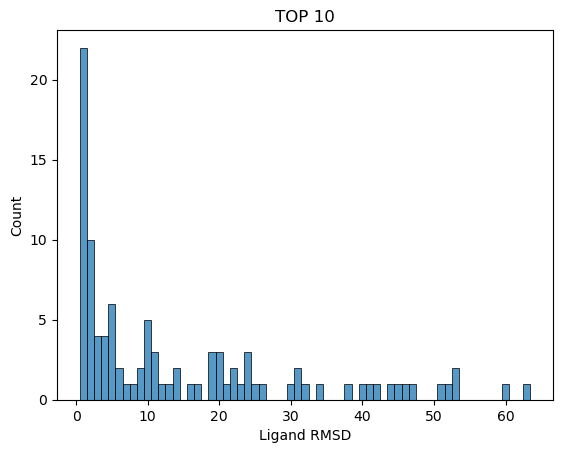

In [29]:
rmsds_top10_copy = copy.deepcopy(rmsds_top10)
histplot(data=rmsds_top10_copy, binwidth=1).set(title='TOP 10', xlabel='Ligand RMSD')

In [37]:
sort_indices = np.argsort(rmsds)
min_indices = sort_indices[:5]
max_indices = sort_indices[-5:]
rmsds[min_indices]

array([0.4533083 , 0.49268275, 0.53249073, 0.5520658 , 0.56543434],
      dtype=float32)

In [64]:
min_indices

array([240, 131, 498, 179, 471])

AttributeError: 'dict' object has no attribute 'dtype'

In [81]:
val_dataset_min = copy.deepcopy(val_dataset)

In [82]:
val_dataset_min.data = [val_dataset_min.data[i] for i in min_indices]
val_dataset_min.length = len(val_dataset_min.data)

In [85]:
# visualize
samples_val_min = sample(val_dataset_min, model, args, visualize_first_n_samples=5, visualization_dir='./visualization/best_samples')


parts: ['receptor']
part: receptor. len: torch.Size([282, 3]). this_vis_values["resname"]: 282
parts: ['ligand']
part: ligand. len: torch.Size([266, 3]). this_vis_values["resname"]: 266
parts: ['ligand']
part: ligand. len: torch.Size([266, 3]). this_vis_values["resname"]: 266
parts: ['receptor']
part: receptor. len: torch.Size([99, 3]). this_vis_values["resname"]: 99
parts: ['ligand']
part: ligand. len: torch.Size([99, 3]). this_vis_values["resname"]: 99
parts: ['ligand']
part: ligand. len: torch.Size([99, 3]). this_vis_values["resname"]: 99
parts: ['receptor']
part: receptor. len: torch.Size([234, 3]). this_vis_values["resname"]: 234
parts: ['ligand']
part: ligand. len: torch.Size([201, 3]). this_vis_values["resname"]: 201
parts: ['ligand']
part: ligand. len: torch.Size([201, 3]). this_vis_values["resname"]: 201
parts: ['receptor']
part: receptor. len: torch.Size([99, 3]). this_vis_values["resname"]: 99
parts: ['ligand']
part: ligand. len: torch.Size([99, 3]). this_vis_values["resname

parts: ['ligand']
part: ligand. len: torch.Size([266, 3]). this_vis_values["resname"]: 266
parts: ['ligand']
part: ligand. len: torch.Size([99, 3]). this_vis_values["resname"]: 99
parts: ['ligand']
part: ligand. len: torch.Size([201, 3]). this_vis_values["resname"]: 201
parts: ['ligand']
part: ligand. len: torch.Size([99, 3]). this_vis_values["resname"]: 99
parts: ['ligand']
part: ligand. len: torch.Size([199, 3]). this_vis_values["resname"]: 199
08:26:44 Completed 14 out of 40 steps
parts: ['ligand']
part: ligand. len: torch.Size([266, 3]). this_vis_values["resname"]: 266
parts: ['ligand']
part: ligand. len: torch.Size([99, 3]). this_vis_values["resname"]: 99
parts: ['ligand']
part: ligand. len: torch.Size([201, 3]). this_vis_values["resname"]: 201
parts: ['ligand']
part: ligand. len: torch.Size([99, 3]). this_vis_values["resname"]: 99
parts: ['ligand']
part: ligand. len: torch.Size([199, 3]). this_vis_values["resname"]: 199
08:26:44 Completed 15 out of 40 steps
parts: ['ligand']
part

parts: ['ligand']
part: ligand. len: torch.Size([266, 3]). this_vis_values["resname"]: 266
parts: ['ligand']
part: ligand. len: torch.Size([99, 3]). this_vis_values["resname"]: 99
parts: ['ligand']
part: ligand. len: torch.Size([201, 3]). this_vis_values["resname"]: 201
parts: ['ligand']
part: ligand. len: torch.Size([99, 3]). this_vis_values["resname"]: 99
parts: ['ligand']
part: ligand. len: torch.Size([199, 3]). this_vis_values["resname"]: 199
08:26:48 Completed 31 out of 40 steps
parts: ['ligand']
part: ligand. len: torch.Size([266, 3]). this_vis_values["resname"]: 266
parts: ['ligand']
part: ligand. len: torch.Size([99, 3]). this_vis_values["resname"]: 99
parts: ['ligand']
part: ligand. len: torch.Size([201, 3]). this_vis_values["resname"]: 201
parts: ['ligand']
part: ligand. len: torch.Size([99, 3]). this_vis_values["resname"]: 99
parts: ['ligand']
part: ligand. len: torch.Size([199, 3]). this_vis_values["resname"]: 199
08:26:48 Completed 32 out of 40 steps
parts: ['ligand']
part

In [84]:
val_score_min = evaluate_pose(val_dataset[min_indices], samples_val_min)
rmsds_min = np.array(val_score_min["rmsd"])
reverse_diffusion_metrics_min = {'rmsds_lt2': (100 * (rmsds_min < 2).sum() / len(rmsds_min)),
                             'rmsds_lt5': (100 * (rmsds_min < 5).sum() / len(rmsds_min)),
                             'rmsds_mean': rmsds_min.mean(),
                             'rmsds_median': np.median(rmsds_min)}
print(reverse_diffusion_metrics_min)

{'rmsds_lt2': 80.0, 'rmsds_lt5': 80.0, 'rmsds_mean': 7.4717817, 'rmsds_median': 1.0037977}


In [42]:
rmsds_min

array([1.2857661 , 0.5547091 , 1.5078617 , 0.46852425, 7.26835   ],
      dtype=float32)

In [86]:
val_dataset_max = copy.deepcopy(val_dataset)

In [87]:
val_dataset_max.data = [val_dataset_max.data[i] for i in max_indices]
val_dataset_max.length = len(val_dataset_max.data)

In [89]:
samples_val_max = sample(val_dataset_max, model, args, visualize_first_n_samples=5, visualization_dir='./visualization/worst_samples')


08:28:50 Completed 0 out of 40 steps
08:28:54 Completed 1 out of 40 steps
08:28:58 Completed 2 out of 40 steps
08:29:01 Completed 3 out of 40 steps
08:29:05 Completed 4 out of 40 steps
08:29:07 Completed 5 out of 40 steps
08:29:10 Completed 6 out of 40 steps
08:29:12 Completed 7 out of 40 steps
08:29:13 Completed 8 out of 40 steps
08:29:15 Completed 9 out of 40 steps
08:29:16 Completed 10 out of 40 steps
08:29:18 Completed 11 out of 40 steps
08:29:19 Completed 12 out of 40 steps
08:29:20 Completed 13 out of 40 steps
08:29:22 Completed 14 out of 40 steps
08:29:23 Completed 15 out of 40 steps
08:29:24 Completed 16 out of 40 steps
08:29:25 Completed 17 out of 40 steps
08:29:26 Completed 18 out of 40 steps
08:29:26 Completed 19 out of 40 steps
08:29:27 Completed 20 out of 40 steps
08:29:28 Completed 21 out of 40 steps
08:29:29 Completed 22 out of 40 steps
08:29:29 Completed 23 out of 40 steps
08:29:30 Completed 24 out of 40 steps
08:29:31 Completed 25 out of 40 steps
08:29:31 Completed 26 

In [44]:
val_score_max = evaluate_pose(val_dataset[max_indices], samples_val_max)
rmsds_max = np.array(val_score_max["rmsd"])
reverse_diffusion_metrics_max = {'rmsds_lt2': (100 * (rmsds_max < 2).sum() / len(rmsds_max)),
                             'rmsds_lt5': (100 * (rmsds_max < 5).sum() / len(rmsds_max)),
                             'rmsds_mean': rmsds_max.mean(),
                             'rmsds_median': np.median(rmsds_max)}
print(reverse_diffusion_metrics_max)

{'rmsds_lt2': 0.0, 'rmsds_lt5': 40.0, 'rmsds_mean': 20.964426, 'rmsds_median': 13.240943}


In [45]:
val_score_max

{'rmsd': [tensor(13.2409),
  tensor(4.1688),
  tensor(3.5944),
  tensor(43.6073),
  tensor(40.2108)]}

tensor(1.0215)


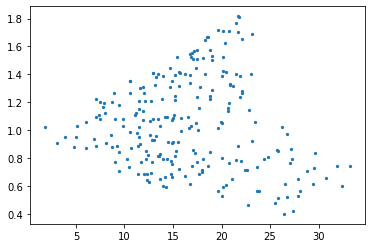

In [207]:
true_graph, pred_graph = val_dataset_without_noise[rmsds.argmin()], samples_val[rmsds.argmin()]
true_xyz = true_graph["ligand"].pos
pred_xyz = pred_graph["ligand"].pos

print(compute_rmsd(true_xyz, pred_xyz))

#dist_from_com = torch.norm(true_xyz-true_xyz.mean(0), p=2, dim=1)
dist_from_com = torch.norm(pred_xyz-pred_xyz.mean(0), p=2, dim=1)


square_deviation_per_residue = ((true_xyz-pred_xyz)**2).sum(-1)
plt.scatter(dist_from_com, square_deviation_per_residue, s=5)
plt.show()


In [15]:
rmsds = np.array([18.55453873, 52.48733139,  0.95979214,  5.29088259, 19.08759308,
       24.22147179,  0.6637181 ,  3.44789147,  0.99152851,  0.87315911,
       13.27579403,  2.43114018,  3.73751402, 14.17319298,  5.36911011,
        0.74436826,  4.82810926,  5.32153845,  1.28382909,  6.08122683,
        3.77207398, 21.30369568, 25.4969902 , 63.19504547, 45.38077545,
        7.71054459, 37.6367836 ,  2.24138761, 51.54737473, 19.49333   ,
        1.11175966, 10.67053699, 12.45097733,  0.82715404,  2.21490097,
       24.13285446, 40.37942123,  0.47576505,  9.71454334, 51.33063126,
       22.13999176,  2.31724572, 24.93940353, 17.03530121, 52.64008331,
        7.09895515,  2.03118896,  1.37214077,  1.55087042,  0.53179914,
        9.84427357,  1.10775387, 46.2383194 ,  1.29177773,  3.62341595,
       31.23996353,  1.40504074, 46.98308563,  9.9671545 , 19.81276894,
       23.2368145 ,  5.21680784,  0.56136   ,  1.06705058, 15.67559147,
       40.68418884,  9.17874718, 30.65575027,  1.34148216, 13.98250389,
        1.35499239, 59.65415573, 42.22156906,  8.85554314,  1.74397933,
       34.10089111,  2.00573063,  9.72453785,  0.87984627, 29.78113937,
        2.86255312,  6.33035898, 32.24247742, 22.36004639, 11.41702271,
        2.98866129, 20.34176826,  0.62147456, 10.13168716, 10.96499729,
       44.09468842,  3.87953281,  0.69320494,  1.92998314, 19.41574669,
        2.70588326,  1.24329674,  2.20317698,  5.34725952, 23.50101471])

In [27]:
from scipy.spatial.distance import cdist

In [31]:
num_residues = []
num_residues_receptor = []
average_dist_from_com = []
max_dist_from_com = []
max_pairwise_dist = []
for true_graph in tqdm(val_dataset):
    
    true_xyz = true_graph["ligand"].pos
        
    true_xyz_receptor = true_graph["receptor"].pos
    
    num_residues.append(true_xyz.shape[0])
    num_residues_receptor.append(true_xyz_receptor.shape[0])
    
    dist_from_com = torch.norm(true_xyz-true_xyz.mean(0), p=2, dim=1)
    average_dist_from_com.append(dist_from_com.mean())
    max_dist_from_com.append(dist_from_com.max())
    
    Y = cdist(true_xyz, true_xyz, 'euclidean')
    max_pairwise_dist.append(Y.max())

    
    #dist_from_com_pred = torch.norm(pred_xyz-pred_xyz.mean(0), p=2, dim=1)
    #print(f'MEAN. true: {dist_from_com.mean()}. pred: {dist_from_com_pred.mean()}')
    #print(f'MAX. true: {dist_from_com.max()}. pred: {dist_from_com_pred.max()}')
    
    #square_deviation_per_residue = ((true_xyz-pred_xyz)**2).sum(-1)
    #plt.scatter(dist_from_com, square_deviation_per_residue, s=5)
    #plt.show()
    #print(true_xyz.shape)
    #print(pred_xyz.shape)
    #break
num_residues = np.array(num_residues)
num_residues_receptor = np.array(num_residues_receptor)
average_dist_from_com = np.array(average_dist_from_com)
max_dist_from_com = np.array(max_dist_from_com)
max_pairwise_dist = np.array(max_pairwise_dist)
print(num_residues.shape)
print(average_dist_from_com.shape)
print(max_dist_from_com.shape)

100%|██████████| 100/100 [00:00<00:00, 211.41it/s]

(100,)
(100,)
(100,)


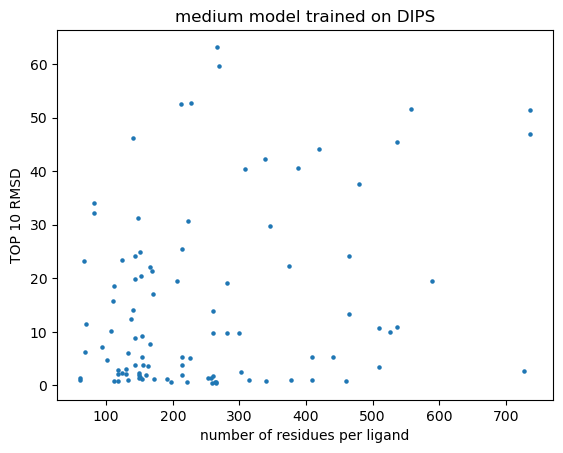

In [18]:
plt.scatter(num_residues, rmsds, s=5)
plt.title("medium model trained on DIPS")
plt.xlabel("number of residues per ligand")
plt.ylabel("TOP 10 RMSD")
plt.show()

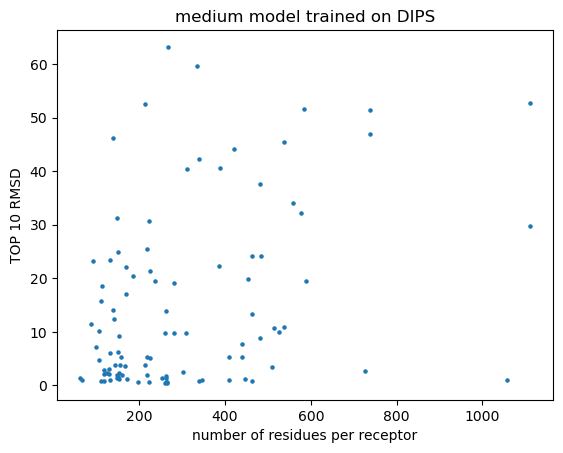

In [22]:
plt.scatter(num_residues_receptor, rmsds, s=5)
plt.title("medium model trained on DIPS")
plt.xlabel("number of residues per receptor")
plt.ylabel("TOP 10 RMSD")
plt.show()

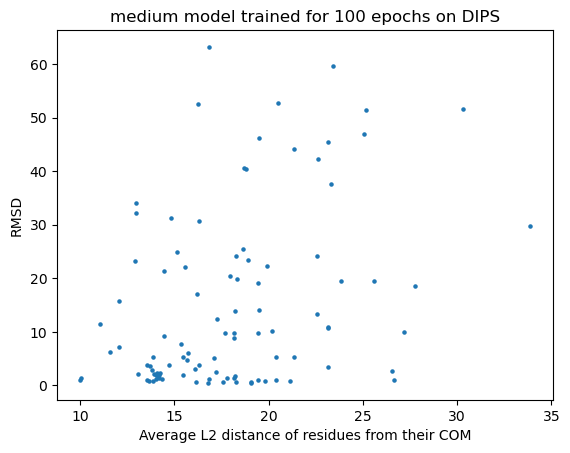

In [19]:
plt.scatter(average_dist_from_com, rmsds, s=5)
plt.title("medium model trained for 100 epochs on DIPS")
plt.xlabel("Average L2 distance of residues from their COM")
plt.ylabel("RMSD")
plt.show()

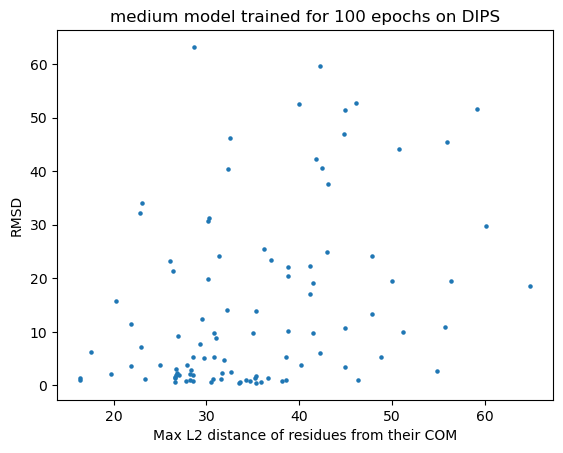

In [20]:
plt.scatter(max_dist_from_com, rmsds, s=5)
plt.title("medium model trained for 100 epochs on DIPS")
plt.xlabel("Max L2 distance of residues from their COM")
plt.ylabel("RMSD")
plt.show()

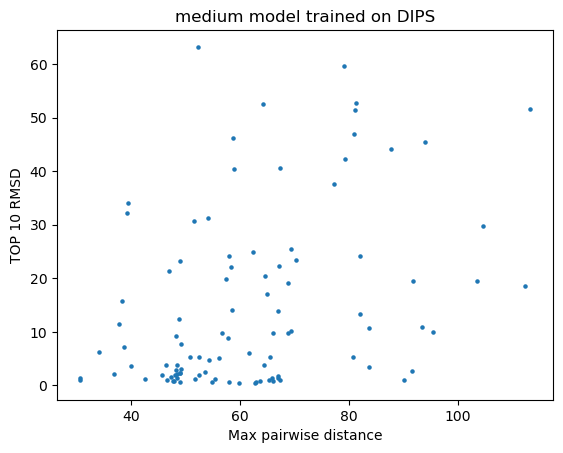

In [32]:
plt.scatter(max_pairwise_dist, rmsds, s=5)
plt.title("medium model trained on DIPS")
plt.xlabel("Max pairwise distance")
plt.ylabel("TOP 10 RMSD")
plt.show()

In [42]:
from torch_geometric.loader import DataLoader

[autoreload of sample failed: Traceback (most recent call last):
  File "/data/rsg/nlp/sdobers/miniconda3/envs/diffdock_protein/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/data/rsg/nlp/sdobers/miniconda3/envs/diffdock_protein/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/data/rsg/nlp/sdobers/miniconda3/envs/diffdock_protein/lib/python3.10/importlib/__init__.py", line 168, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'sample'
]


In [44]:
test_loader = DataLoader(val_loader, batch_size=args.batch_size)

In [54]:
for complex_graphs in test_loader:
    complex_graphs = complex_graphs.cuda()
    print(complex_graphs["ligand"]['node_t']['tr'].device)
    break

cuda:1
